In [13]:
import logging

import numpy as np
import xgboost as xgb
import talib
from binance.enums import HistoricalKlinesType
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from main_funcs import get_and_update_data

In [14]:
# configs
country=None
joft = "BTCUSDT"
interval = "4h"

# remove small candle 
zero_remover_pct = 0.00

# add history of open_close_pct 
open_close_pct_history_count = 60

# add history of max_low_high_pct 
max_low_high_pct_history_count = -1

# calculate rsi with different lengths 
rsi_ranges = range(14, 14)

# add history of rsi
rsi_history_count = 0

# add moving average of rsi
rsi_ma_lengths = [3,7,9,10,14,20,50,100]
rsi_ma_ranges = []


In [15]:
# validation config

# valid rsi_ma_ranges
for r in  rsi_ma_ranges:
    if not r in rsi_ranges:
        raise ValueError("rsi_ma_ranges items is not in rsi_ranges")

In [16]:
# get data from database
df_source = get_and_update_data(joft, interval, HistoricalKlinesType.SPOT, country=country)
df_source = df_source[["open", "high", "low", "close", "volume"]]
# df_source.tail(1)

In [17]:
# calculate parameters
df_cal = df_source.copy()

# change from open to other columns
df_cal['open_close'] = df_cal.close - df_cal.open
df_cal['open_low'] = df_cal.low - df_cal.open
df_cal['open_high'] = df_cal.high - df_cal.open

# change percent from open to other columns
df_cal['open_close_pct'] = df_cal.open_close / df_cal.open
df_cal['open_low_pct'] = df_cal.open_low / df_cal.open
df_cal['open_high_pct'] = df_cal.open_high / df_cal.open

# price direction
# df_target['open_close_direction'] = np.sign(df_target["open_close"])
# df_target['open_open_high_direction'] = np.sign(df_target["open_low"]).astype(int)
# df_target['open_high_direction'] = np.sign(df_target["open_high"]).astype(int)

# max abs low and high
df_cal['max_low_high_pct'] = np.where(
    df_cal['open_low_pct'].abs() > df_cal['open_high_pct'].abs(),
    df_cal['open_low_pct'],
    df_cal['open_high_pct']
)

# open_close_pct history
for h in range(0,open_close_pct_history_count+1):
    df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
    

# max_low_high_pct history
for h in range(0,max_low_high_pct_history_count+1):
    df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
    

# calculate multi rsi
for rsi in rsi_ranges:
    for h in range(0, rsi_history_count + 1):
        df_cal[f"rsi_{rsi}__{h}"] = talib.RSI(df_cal.close.shift(h), timeperiod=rsi)
        
# calculate rsi sma 
for ma_length in rsi_ma_lengths:
    for rsi in rsi_ma_ranges:
        df_cal[f"rsi_{rsi}_ma_{ma_length}"] =  talib.SMA(df_cal[f"rsi_{rsi}__{0}"], timeperiod=ma_length)
# df_cal

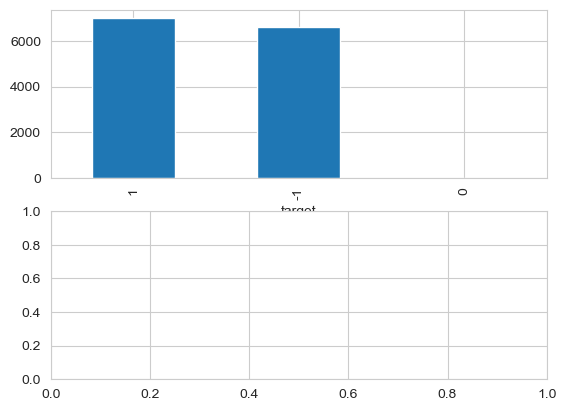

In [18]:
# create calculate target
df_target = df_cal.copy()
# mabna = 'max_low_high_pct'
mabna = 'open_close_pct'

# calculate target
df_target["target"] = np.where(
    df_target[mabna] > zero_remover_pct,
    1,
    np.where(
        df_target[mabna] < -zero_remover_pct,
        -1, 0
    )
)

# convert -1 and 1 and 0 to True False for better result
# df_target["target"] = np.where(df_target['target'] ==1, 1,0)


# show chart
fig, axs = plt.subplots(2, 1)
df_target["target"].value_counts().plot(kind='bar', ax=axs[0])
# (np.sign(df_target["open_close"]) == np.sign(df_target["target"])).value_counts().plot(kind='bar',ax=axs[1])

# shift target the real place
df_target["target"] = df_target["target"].shift(-1)
# df_target

In [19]:
# clean data
df = df_target.copy()
df.dropna(inplace=True)
df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'open_close', 'open_low', 'open_high',
                 'open_close_pct', 'open_low_pct', 'open_high_pct', 'max_low_high_pct'], inplace=True)
df

,open_close_pct__0,open_close_pct__1,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__5,open_close_pct__6,open_close_pct__7,open_close_pct__8,open_close_pct__9,...,open_close_pct__52,open_close_pct__53,open_close_pct__54,open_close_pct__55,open_close_pct__56,open_close_pct__57,open_close_pct__58,open_close_pct__59,open_close_pct__60,target
open_time,,,,,,,,,,,,,,,,,,,,,
2017-08-27 07:30:00,-0.003546,-0.004062,0.010229,0.004332,-0.003199,-0.007172,0.005063,0.004025,-0.010476,-0.019841,...,-0.019356,0.012908,0.001831,0.001706,-0.005219,-0.006227,-0.018873,0.021688,0.020770,-1.0
2017-08-27 11:30:00,-0.001829,-0.003546,-0.004062,0.010229,0.004332,-0.003199,-0.007172,0.005063,0.004025,-0.010476,...,-0.023204,-0.019356,0.012908,0.001831,0.001706,-0.005219,-0.006227,-0.018873,0.021688,-1.0
2017-08-27 15:30:00,-0.003456,-0.001829,-0.003546,-0.004062,0.010229,0.004332,-0.003199,-0.007172,0.005063,0.004025,...,-0.006440,-0.023204,-0.019356,0.012908,0.001831,0.001706,-0.005219,-0.006227,-0.018873,1.0
2017-08-27 19:30:00,0.018275,-0.003456,-0.001829,-0.003546,-0.004062,0.010229,0.004332,-0.003199,-0.007172,0.005063,...,0.007346,-0.006440,-0.023204,-0.019356,0.012908,0.001831,0.001706,-0.005219,-0.006227,-1.0
2017-08-27 23:30:00,-0.006022,0.018275,-0.003456,-0.001829,-0.003546,-0.004062,0.010229,0.004332,-0.003199,-0.007172,...,-0.025379,0.007346,-0.006440,-0.023204,-0.019356,0.012908,0.001831,0.001706,-0.005219,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 19:30:00,-0.001267,0.002607,-0.001951,0.003763,-0.003803,-0.000506,0.002645,0.001683,-0.000483,-0.000906,...,-0.000227,0.005389,-0.006702,0.014928,-0.006168,-0.006255,-0.007431,-0.001669,0.010393,-1.0
2023-11-12 23:30:00,-0.001101,-0.001267,0.002607,-0.001951,0.003763,-0.003803,-0.000506,0.002645,0.001683,-0.000483,...,0.001702,-0.000227,0.005389,-0.006702,0.014928,-0.006168,-0.006255,-0.007431,-0.001669,-1.0
2023-11-13 03:30:00,-0.004050,-0.001101,-0.001267,0.002607,-0.001951,0.003763,-0.003803,-0.000506,0.002645,0.001683,...,-0.001600,0.001702,-0.000227,0.005389,-0.006702,0.014928,-0.006168,-0.006255,-0.007431,1.0


In [20]:
# analyse df
print("shape df: ", df.shape)
df.corr()['target'].sort_values(ascending=False)

shape df:  (13600, 62)


target                1.000000
open_close_pct__3     0.027575
open_close_pct__15    0.020472
open_close_pct__39    0.018270
open_close_pct__28    0.018233
                        ...   
open_close_pct__40   -0.013572
open_close_pct__1    -0.015746
open_close_pct__18   -0.020356
open_close_pct__5    -0.059005
open_close_pct__0    -0.070055
Name: target, Length: 62, dtype: float64

In [21]:
# create cross validator
# Data and targets
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [ ]:
params = {
    'C': [1, 5, 10, 15],
    'kernel': ['linear'],
    'gamma': ['auto', 0.1, 0.5]
}
gsh = GridSearchCV(
    SVC(), 
    param_grid=params,
    scoring='accuracy',
    cv=4, # cross value parts 
    n_jobs=-1, # use all cpu
    verbose=10
)
gsh.fit(X,Y)

print("best_estimator_",gsh.best_estimator_)
print("best_score_",gsh.best_score_)
print("best_params_v",gsh.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


In [22]:
rs_param_grid = {
    'max_depth': list((range(3,50,))),
    'alpha': [0,0.001, 0.01,0.1,1],
    'subsample': [0.5,0.75,1],
    'learning_rate': np.linspace(0.01,0.5, 10),
    'n_estimators': [10, 25, 40]
}

xgb_clf = xgb.XGBClassifier(random_state=123)
xgb_rs = RandomizedSearchCV(estimator=xgb_clf,param_distributions=rs_param_grid,
                            cv=5, n_iter=5, verbose=2, random_state=123)

le = LabelEncoder()
Y_transform = le.fit_transform(Y)
xgb_rs.fit(X, Y_transform)
print("==========================")
print("best_estimator_",xgb_rs.best_estimator_)
print("best_score_",xgb_rs.best_score_)
print("best_params_v",xgb_rs.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\sajja\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV] END alpha=1, learning_rate=0.3911111111111111, max_depth=12, n_estimators=25, subsample=0.75; total time=   2.0s
[CV] END alpha=1, learning_rate=0.3911111111111111, max_depth=12, n_estimators=25, subsample=0.75; total time=   2.2s
[CV] END alpha=1, learning_rate=0.3911111111111111, max_depth=12, n_estimators=25, subsample=0.75; total time=   2.2s
[CV] END alpha=1, learning_rate=0.3911111111111111, max_depth=12, n_estimators=25, subsample=0.75; total time=   2.2s
[CV] END alpha=1, learning_rate=0.3911111111111111, max_depth=12, n_estimators=25, subsample=0.75; total time=   2.1s
[CV] END alpha=0.1, learning_rate=0.3911111111111111, max_depth=11, n_estimators=10, subsample=1; total time=   0.9s
[CV] END alpha=0.1, learning_rate=0.3911111111111111, max_depth=11, n_estimators=10, subsample=1; total time=   0.9s
[CV] END alpha=0.1, learning_rate=0.3911111111111111, max_depth=11, n_estimators=10, subsample=1; total time=   0.9s
[CV] END alpha=0.1, learning_rate=0.3911111111111111, max_d